# 09. Pytorch mdoel Deployment

What is model deployment ?

Machine Learning model deployment is the act of making your machine learning models available to someone or something else.

# 0. Get Setup

In [1]:
# For this notebook to run with updated APIs, we need torch 1.12+ and torchvision 0.13+

# Make sure you have torch 1.12+ and torchvision 0.13+

# 1. Getting Data

The dataset we're going to use for deploying a FoodVision Mini is..
Pizza, stack , sushi 20% dataset(pizza, stack, sushi, classes from Food101, random 20% of smple)

In [2]:
# Continue with regular imports
import matplotlib.pyplot as plt
import torch
import torchvision

from torch import nn
from torchvision import transforms

# Try to get torchinfo, install it if it doesn't work
try:
    from torchinfo import summary
except:
    print("[INFO] Couldn't find torchinfo... installing it.")
    !pip install -q torchinfo
    from torchinfo import summary

# Try to import the going_modular directory, download it from GitHub if it doesn't work
try:
    from going_modular.going_modular import data_setup, engine
    from helper_functions import download_data, set_seeds, plot_loss_curves
except:
    # Get the going_modular scripts
    print("[INFO] Couldn't find going_modular or helper_functions scripts... downloading them from GitHub.")
    !git clone https://github.com/mrdbourke/pytorch-deep-learning
    !mv pytorch-deep-learning/going_modular .
    !mv pytorch-deep-learning/helper_functions.py . # get the helper_functions.py script
    !rm -rf pytorch-deep-learning
    from going_modular.going_modular import data_setup, engine
    from helper_functions import download_data, set_seeds, plot_loss_curves

[INFO] Couldn't find torchinfo... installing it.
[INFO] Couldn't find going_modular or helper_functions scripts... downloading them from GitHub.
Cloning into 'pytorch-deep-learning'...
remote: Enumerating objects: 3830, done.
remote: Counting objects: 100% (473/473), done.
remote: Compressing objects: 100% (264/264), done.
remote: Total 3830 (delta 248), reused 400 (delta 202), pack-reused 3357
Receiving objects: 100% (3830/3830), 649.88 MiB | 16.05 MiB/s, done.
Resolving deltas: 100% (2204/2204), done.
Updating files: 100% (248/248), done.


In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [4]:
# Download pizza, steak, sushi images from GitHub
data_20_percent_path = download_data(source="https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi_20_percent.zip",
                                     destination="pizza_steak_sushi_20_percent")

data_20_percent_path

[INFO] Did not find data/pizza_steak_sushi_20_percent directory, creating one...
[INFO] Downloading pizza_steak_sushi_20_percent.zip from https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi_20_percent.zip...
[INFO] Unzipping pizza_steak_sushi_20_percent.zip data...


PosixPath('data/pizza_steak_sushi_20_percent')

In [5]:
# Setup train dir and test dir
train_dir = data_20_percent_path / "train"
test_dir = data_20_percent_path / "test"

train_dir, test_dir

(PosixPath('data/pizza_steak_sushi_20_percent/train'),
 PosixPath('data/pizza_steak_sushi_20_percent/test'))

## 2. FoodVision Mini model deployment experiment outline

### 3 Questions

1. What is my most ideal machine learning model deployment scenario ?
2. Where is my model going to go ?
3. How is my model going to function ?

** FoodVision Mini ideal use case: ** A model that performs well and fast.

* Performs well: 95% + accuracy
* Fast: as close to real-time (or faster) as possible (30FPS+ or 30ms latency)

We're going to built two model experiments:
  1. EffNetB2 feature extractor (just like in 07. Pytorch Experiment tracking)
  2. ViT feature extractor (just like in 08. Pytorch paper Replicating)

## 3. Creating an EffNetB2 feature Extractor

Feature extractor = a tearm for a transfer learning model that has its base layers frozen and output layers (or head layers) customized to a certain problem.

EffNetB2 pretrained model in PyTorch -
https://pytorch.org/vision/stable/models/generated/torchvision.models.efficientnet_b2.html#torchvision.models.EfficientNet_B2_Weights

In [6]:
from torchvision.models import Weights
import torchvision

# 1. Setup pretrained EffNetB2 weights
effnetb2_weights = torchvision.models.EfficientNet_B2_Weights.DEFAULT # "DEFAULT =  Best Available"

# 2. Get EffNetB2 transforms
effnetb2_transforms = effnetb2_weights.transforms()

# 3. Setup pretrained model instance
effnetb2 = torchvision.models.efficientnet_b2(weights = effnetb2_weights) # could also use "Weights = DEFAULT"

# 4. Freeze the base layers in the model (this will stop all layers from training)
for param in effnetb2.parameters():
  param.requires_grad = False

Downloading: "https://download.pytorch.org/models/efficientnet_b2_rwightman-bcdf34b7.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b2_rwightman-bcdf34b7.pth
100%|██████████| 35.2M/35.2M [00:00<00:00, 55.8MB/s]


In [7]:
from torchinfo import summary

summary(model=effnetb2,
        input_size=(1,3,224,224),
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [1, 3, 224, 224]     [1, 1000]            --                   False
├─Sequential (features)                                      [1, 3, 224, 224]     [1, 1408, 7, 7]      --                   False
│    └─Conv2dNormActivation (0)                              [1, 3, 224, 224]     [1, 32, 112, 112]    --                   False
│    │    └─Conv2d (0)                                       [1, 3, 224, 224]     [1, 32, 112, 112]    (864)                False
│    │    └─BatchNorm2d (1)                                  [1, 32, 112, 112]    [1, 32, 112, 112]    (64)                 False
│    │    └─SiLU (2)                                         [1, 32, 112, 112]    [1, 32, 112, 112]    --                   --
│    └─Sequential (1)                                        [1, 32, 112, 112]    [1, 16,

In [8]:
effnetb2.classifier

Sequential(
  (0): Dropout(p=0.3, inplace=True)
  (1): Linear(in_features=1408, out_features=1000, bias=True)
)

In [9]:
effnetb2.classifier = nn.Sequential(
    nn.Dropout(p=0.3, inplace = True),
    nn.Linear(in_features=1408, out_features=3, bias=True)
)

In [10]:
from torchinfo import summary

summary(model=effnetb2,
        input_size=(1,3,224,224),
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [1, 3, 224, 224]     [1, 3]               --                   Partial
├─Sequential (features)                                      [1, 3, 224, 224]     [1, 1408, 7, 7]      --                   False
│    └─Conv2dNormActivation (0)                              [1, 3, 224, 224]     [1, 32, 112, 112]    --                   False
│    │    └─Conv2d (0)                                       [1, 3, 224, 224]     [1, 32, 112, 112]    (864)                False
│    │    └─BatchNorm2d (1)                                  [1, 32, 112, 112]    [1, 32, 112, 112]    (64)                 False
│    │    └─SiLU (2)                                         [1, 32, 112, 112]    [1, 32, 112, 112]    --                   --
│    └─Sequential (1)                                        [1, 32, 112, 112]    [1, 1

### 3.1 Creating a function to make an EffNetB2 feature extractor

In [11]:
def create_effnetb2_model(num_classes:int=3, # default output classes = 3(pizza, stack, sushi)
                          seed:int=42):
    # 1,2,3 Create EffNetB2 pretrained weights, transforms and model
    weights = torchvision.models.EfficientNet_B2_Weights.DEFAULT # "DEFAULT = Best available"
    transforms = weights.transforms()
    model = torchvision.models.efficientnet_b2(weights=weights)

    # 4. Freeze all layers in base model
    for params in model.parameters():
      params.requires_grad = False

    # 5. Change classifier
    # torch.manual_seed()
    model.classifier = nn.Sequential(
        nn.Dropout(p=0.3, inplace=True),
        nn.Linear(in_features=1408, out_features=num_classes, bias=True)
)

    return model, transforms

In [12]:
effnetb2, effnetb2_transforms = create_effnetb2_model(num_classes=3)

In [13]:
from torchinfo import summary

summary(model=effnetb2,
        input_size=(1, 3, 224, 224),
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [1, 3, 224, 224]     [1, 3]               --                   Partial
├─Sequential (features)                                      [1, 3, 224, 224]     [1, 1408, 7, 7]      --                   False
│    └─Conv2dNormActivation (0)                              [1, 3, 224, 224]     [1, 32, 112, 112]    --                   False
│    │    └─Conv2d (0)                                       [1, 3, 224, 224]     [1, 32, 112, 112]    (864)                False
│    │    └─BatchNorm2d (1)                                  [1, 32, 112, 112]    [1, 32, 112, 112]    (64)                 False
│    │    └─SiLU (2)                                         [1, 32, 112, 112]    [1, 32, 112, 112]    --                   --
│    └─Sequential (1)                                        [1, 32, 112, 112]    [1, 1

In [14]:
effnetb2_transforms

ImageClassification(
    crop_size=[288]
    resize_size=[288]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BICUBIC
)

### 3.2 Creating Dataloaders

In [15]:
# Setup Dataloaders
from going_modular.going_modular import data_setup

train_dataloader_effnetb2, test_dataloader_effnetb2, class_names = data_setup.create_dataloaders(train_dir=train_dir,
                                                                                                 test_dir=test_dir,
                                                                                                 transform=effnetb2_transforms,
                                                                                                 batch_size=32)

In [16]:
len(train_dataloader_effnetb2), len(test_dataloader_effnetb2), class_names

(15, 5, ['pizza', 'steak', 'sushi'])

### 3.3 Training EffNetB2 feature extractor

In [17]:
from going_modular.going_modular import engine

# Loss function
loss_fn = torch.nn.CrossEntropyLoss()

# Optimizer
optimizer = torch.optim.Adam(params=effnetb2.parameters(),
                             lr=1e-3)

# Training function (engine.py)
effnetb2_results = engine.train(model=effnetb2,
                                train_dataloader=train_dataloader_effnetb2,
                                test_dataloader=test_dataloader_effnetb2,
                                epochs=10,
                                optimizer=optimizer,
                                loss_fn=loss_fn,
                                device=device)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.9420 | train_acc: 0.6146 | test_loss: 0.7159 | test_acc: 0.9227
Epoch: 2 | train_loss: 0.6790 | train_acc: 0.8729 | test_loss: 0.5890 | test_acc: 0.9534
Epoch: 3 | train_loss: 0.5271 | train_acc: 0.9083 | test_loss: 0.4881 | test_acc: 0.9409
Epoch: 4 | train_loss: 0.4912 | train_acc: 0.8729 | test_loss: 0.4265 | test_acc: 0.9534
Epoch: 5 | train_loss: 0.4350 | train_acc: 0.8688 | test_loss: 0.3675 | test_acc: 0.9597
Epoch: 6 | train_loss: 0.3670 | train_acc: 0.9146 | test_loss: 0.3437 | test_acc: 0.9597
Epoch: 7 | train_loss: 0.3932 | train_acc: 0.9021 | test_loss: 0.3392 | test_acc: 0.9597
Epoch: 8 | train_loss: 0.3266 | train_acc: 0.9125 | test_loss: 0.3104 | test_acc: 0.9472
Epoch: 9 | train_loss: 0.3456 | train_acc: 0.9021 | test_loss: 0.3044 | test_acc: 0.9534
Epoch: 10 | train_loss: 0.4063 | train_acc: 0.8792 | test_loss: 0.2819 | test_acc: 0.9443


### 3.4 Inspecting EffnetB2 Loss curves

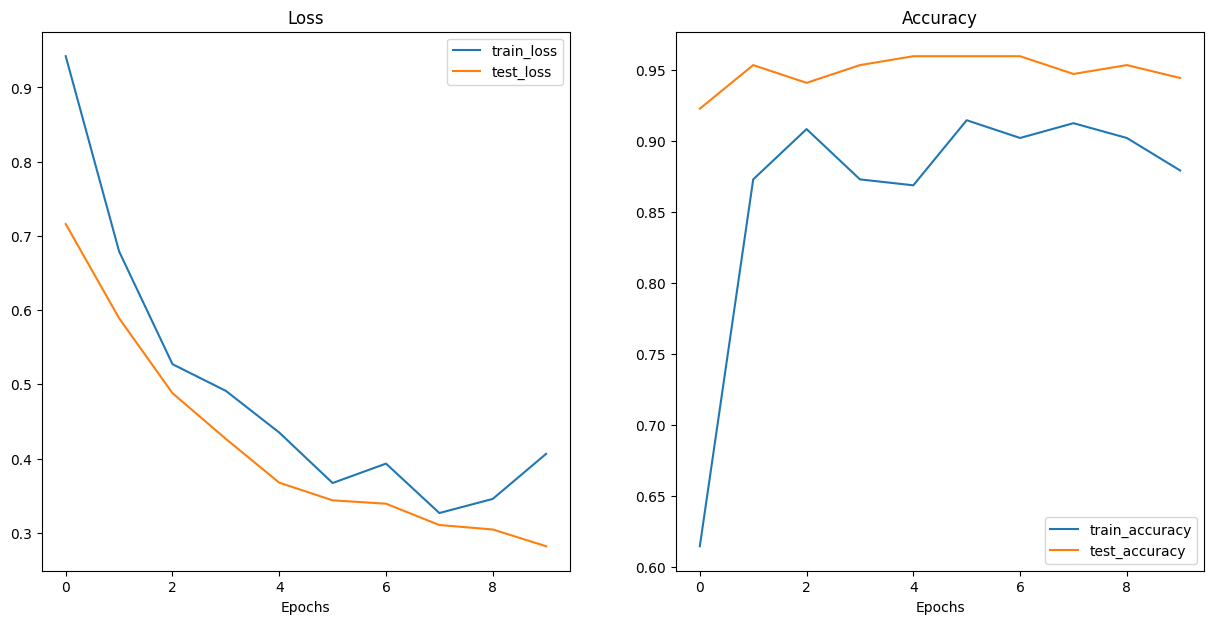

In [18]:
from helper_functions import plot_loss_curves

plot_loss_curves(effnetb2_results)

### 3.5 Saving EffnetB2 feature extractor


In [19]:
from going_modular.going_modular import utils

# Save the model
utils.save_model(model=effnetb2,
                 target_dir="models",
                 model_name="09_pretrained_effnetb2_feature_extractor_pizza_stack_sushi_20_percent.pth")

[INFO] Saving model to: models/09_pretrained_effnetb2_feature_extractor_pizza_stack_sushi_20_percent.pth


### 3.6 Inspacting the size of out Effnetb2 feature extractor

In [20]:
from pathlib import Path

# Get the model size in bytes and convert to megabytes
pretrained_effnetb2_model_size = Path("models/09_pretrained_effnetb2_feature_extractor_pizza_stack_sushi_20_percent.pth").stat().st_size / (1024 * 1024)
pretrained_effnetb2_model_size

29.863232612609863

### 3.7 Collecting EffNetB2 feature extractor stats

In [21]:
# Count number of parameters in EffNetB2
effnetb2_total_params = sum(torch.numel(param) for param in effnetb2.parameters())
effnetb2_total_params

7705221

In [22]:
# Create a dictionary with EffnetB2 statistics
effnetb2_stats = {"test_loss": effnetb2_results["test_loss"][-1],
                  "test_acc": effnetb2_results["test_acc"][-1],
                  "number_of_parameters":effnetb2_total_params,
                  "model_size (MB)":pretrained_effnetb2_model_size}

effnetb2_stats

{'test_loss': 0.28188291788101194,
 'test_acc': 0.9443181818181818,
 'number_of_parameters': 7705221,
 'model_size (MB)': 29.863232612609863}

## 4. Creating a ViT feature extractor

In [23]:
# Check out the ViT head layer
vit = torchvision.models.vit_b_16()
vit.heads

Sequential(
  (head): Linear(in_features=768, out_features=1000, bias=True)
)

In [24]:
def create_vit_model(num_classes:int=3,
                     seed:int=42):

  # Create ViT_B_16 pretrained weights, transforms and model
  weights = torchvision.models.ViT_B_16_Weights.DEFAULT
  transforms = weights.transforms()
  model = torchvision.models.vit_b_16(weights=weights)

  # Freeze all of the base layers
  for param in model.parameters():
        param.requires_grad = False

    # Change classifier head to suit our needs
    # torch.manual_seed(seed)
  model.heads = nn.Sequential(
                nn.Linear(in_features=768,
                out_features=num_classes, bias=True)
                )

  return model, transforms

In [25]:
vit, vit_transforms = create_vit_model()
vit_transforms

Downloading: "https://download.pytorch.org/models/vit_b_16-c867db91.pth" to /root/.cache/torch/hub/checkpoints/vit_b_16-c867db91.pth
100%|██████████| 330M/330M [00:06<00:00, 56.9MB/s]


ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BILINEAR
)

In [26]:
effnetb2_transforms

ImageClassification(
    crop_size=[288]
    resize_size=[288]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BICUBIC
)

In [27]:
from torchinfo import summary

summary(model=vit,
        input_size=(1, 3, 224, 224),
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
VisionTransformer (VisionTransformer)                        [1, 3, 224, 224]     [1, 3]               768                  Partial
├─Conv2d (conv_proj)                                         [1, 3, 224, 224]     [1, 768, 14, 14]     (590,592)            False
├─Encoder (encoder)                                          [1, 197, 768]        [1, 197, 768]        151,296              False
│    └─Dropout (dropout)                                     [1, 197, 768]        [1, 197, 768]        --                   --
│    └─Sequential (layers)                                   [1, 197, 768]        [1, 197, 768]        --                   False
│    │    └─EncoderBlock (encoder_layer_0)                   [1, 197, 768]        [1, 197, 768]        (7,087,872)          False
│    │    └─EncoderBlock (encoder_layer_1)                   [1, 197, 768]        [1, 1

### 4.1 Create Dataloaders for ViT feature extractor

In [28]:
# Setup Vit DataLoaders
from going_modular.going_modular import data_setup
train_dataloaders_vit, test_dataloaders_vit, class_names = data_setup.create_dataloaders(train_dir=train_dir,
                                                                                         test_dir= test_dir,
                                                                                         transform=vit_transforms,
                                                                                         batch_size=32)
len(train_dataloaders_vit), len(test_dataloaders_vit), class_names

(15, 5, ['pizza', 'steak', 'sushi'])

### 4.2 Training ViT Feature Extractor

We're up to model experiment number two: a ViT feature extractor.

In [29]:
from going_modular.going_modular import engine

# Setup optimizer
optimizer = torch.optim.Adam(params=vit.parameters(),
                             lr=1e-3)
# Setup loss function
loss_fn = torch.nn.CrossEntropyLoss()

vit_results = engine.train(model=vit,
                           train_dataloader =train_dataloaders_vit,
                           test_dataloader = test_dataloaders_vit,
                          epochs=10,
                           optimizer=optimizer,
                           loss_fn = loss_fn,
                           device=device)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.5261 | train_acc: 0.8604 | test_loss: 0.1978 | test_acc: 0.9750
Epoch: 2 | train_loss: 0.1909 | train_acc: 0.9583 | test_loss: 0.1043 | test_acc: 0.9875
Epoch: 3 | train_loss: 0.2053 | train_acc: 0.9333 | test_loss: 0.0834 | test_acc: 0.9875
Epoch: 4 | train_loss: 0.1132 | train_acc: 0.9708 | test_loss: 0.0829 | test_acc: 0.9938
Epoch: 5 | train_loss: 0.1048 | train_acc: 0.9750 | test_loss: 0.0709 | test_acc: 0.9938
Epoch: 6 | train_loss: 0.0833 | train_acc: 0.9771 | test_loss: 0.0617 | test_acc: 0.9938
Epoch: 7 | train_loss: 0.0767 | train_acc: 0.9833 | test_loss: 0.0560 | test_acc: 0.9938
Epoch: 8 | train_loss: 0.0688 | train_acc: 0.9875 | test_loss: 0.0537 | test_acc: 0.9938
Epoch: 9 | train_loss: 0.0694 | train_acc: 0.9917 | test_loss: 0.0535 | test_acc: 0.9938
Epoch: 10 | train_loss: 0.0529 | train_acc: 0.9917 | test_loss: 0.0524 | test_acc: 0.9938


### 4.3 Plot loss Curves of ViT feature extractor

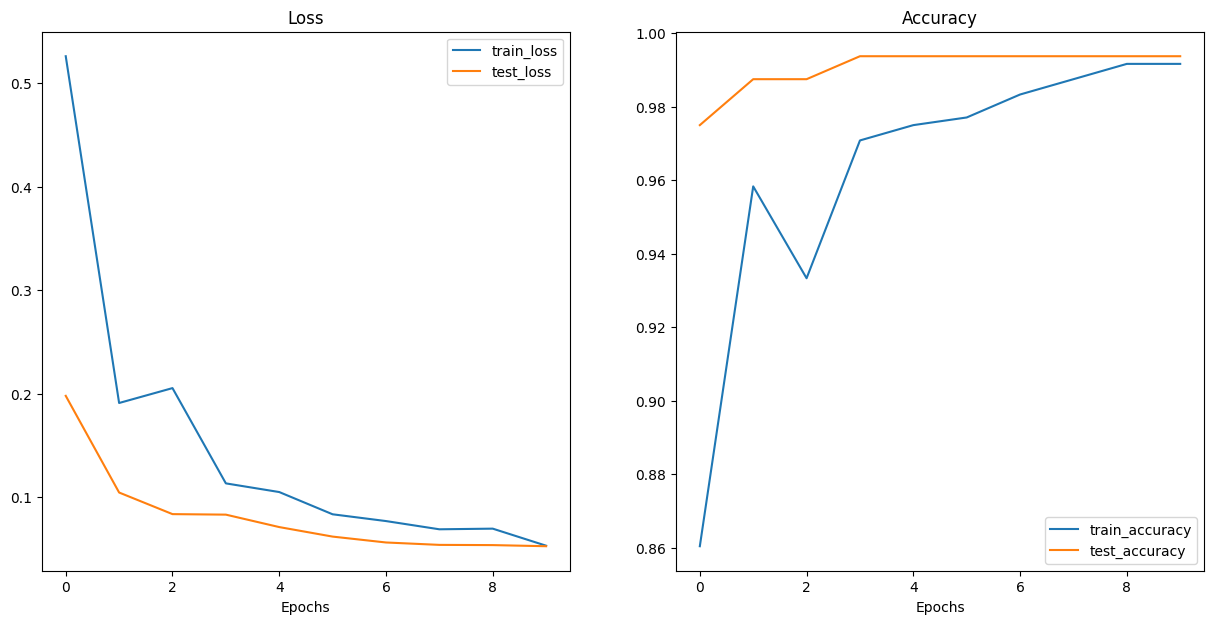

In [30]:
from helper_functions import plot_loss_curves

plot_loss_curves(vit_results)

### 4.4 Saving vit feature extractor

In [31]:
# Save model
from going_modular.going_modular import utils

utils.save_model(model=vit,
                 target_dir="models",
                 model_name="09_pretrained_vit_feature_extractor_pizza_steak_sushi_20_percent.pth")

[INFO] Saving model to: models/09_pretrained_vit_feature_extractor_pizza_steak_sushi_20_percent.pth


### 4.5 Checking the size of ViT feature extractor

In [32]:
from pathlib import Path

# Get the model in byte then convert to MB
pretrained_vit_model_size = Path("models/09_pretrained_vit_feature_extractor_pizza_steak_sushi_20_percent.pth").stat().st_size / (1024*1024)
print(f"Pretrained ViT feature extractor model size: {pretrained_vit_model_size}")

Pretrained ViT feature extractor model size: 327.37038707733154


In [33]:
pretrained_effnetb2_model_size

29.863232612609863

### 4.6 Collecting ViT feature extractor stats

In [34]:
# Count number of parameters in ViT
vit_total_params = sum(torch.numel(param) for param in vit.parameters())
vit_total_params

85800963

In [35]:
effnetb2_total_params

7705221

In [36]:
# Create ViT statistics dictionary
vit_stats = {"test_loss": vit_results["test_loss"][-1],
             "test_acc": vit_results["test_acc"][-1],
             "number_of_parameters":vit_total_params,
             "model_size (MB)": pretrained_vit_model_size}

In [37]:
vit_stats

{'test_loss': 0.0523903304245323,
 'test_acc': 0.99375,
 'number_of_parameters': 85800963,
 'model_size (MB)': 327.37038707733154}

## 5. Making predictions with our trained models and timing them

Our goal:
1. Performs well (95%+ test accuracy)
2. Fast (30fps +)


In [38]:
from pathlib import Path

# Get all test data paths
test_data_paths = list(Path(test_dir).glob("*/*.jpg"))
test_data_paths[:5]

[PosixPath('data/pizza_steak_sushi_20_percent/test/steak/2069289.jpg'),
 PosixPath('data/pizza_steak_sushi_20_percent/test/steak/1335842.jpg'),
 PosixPath('data/pizza_steak_sushi_20_percent/test/steak/550687.jpg'),
 PosixPath('data/pizza_steak_sushi_20_percent/test/steak/670345.jpg'),
 PosixPath('data/pizza_steak_sushi_20_percent/test/steak/730464.jpg')]

### 5.1 Creating a fucntion to make prediction across test_dataset

Now we've got a list of our test image paths, let's get to work on our pred_and_store() function:

1. Create a function that takes a list of paths, a trained PyTorch model, a series of transforms (to prepare images), a list of target class names and a target device.

2. Create an empty list to store prediction dictionaries (we want the function to return a list of dictionaries, one for each prediction).

3. Loop through the target input paths (steps 4-14 will happen inside the loop).

4. Create an empty dictionary for each iteration in the loop to store prediction values per sample.

5. Get the sample path and ground truth class name (we can do this by infering the class from the path).

6. Start the prediction timer using Python's timeit.default_timer().
Open the image using PIL.Image.open(path).

7. Transform the image so it's capable of being using with the target model as well as add a batch dimension and send the image to the target device.

8. Prepare the model for inference by sending it to the target device and turning on eval() mode.

9. Turn on torch.inference_mode() and pass the target transformed image to the model and calculate the prediction probability using torch.softmax() and the target label using torch.argmax().

10. Add the prediction probability and prediction class to the prediction dictionary created in step 4. Also make sure the prediction probability is on the CPU so it can be used with non-GPU libraries such as NumPy and pandas for later inspection.

11. End the prediction timer started in step 6 and add the time to the prediction dictionary created in step 6.

12. See if the predicted class matches the ground truth class from step 5 and add the result to the prediction dictionary created in step 4.

13. Append the updated prediction dictionary to the empty list of predictions created in step 2.

14. Return the list of prediction dictionaries.

In [39]:
import pathlib
import torch
from PIL import Image
from timeit import default_timer as time
from tqdm.auto import tqdm

from typing import List, Dict
# 1. Create a function that takes a list of paths, a trained PyTorch model, a series of transforms (to prepare images), a list of target class names and a target device.
def pred_and_store(paths: List[pathlib.Path],
                   model: torch.nn.Module,
                   transform: torchvision.transforms,
                   class_names: List[str],
                   device: str = "cuda" if torch.cuda.is_available() else "cpu") -> List[Dict]:
  # 2. Create an empty list to store prediction dictionaries.
  pred_list = []

  # 3. Loop through the target input paths (steps 4-14 will happen inside the loop).
  for path in tqdm(paths):

    # 4. Create an empty dictionary for each iteration in the loop to store prediction values per sample.
    pred_dict = {}

    # 5. Get the sample path and ground truth class name (we can do this by infering the class from the path).
    pred_dict["image_path"] = path
    class_name = path.parent.stem
    pred_dict["class_name"] = class_name

    # 6. Start the prediction timer using Python's timeit.default_timer(). Open the image using PIL.Image.open(path).
    start_time = time()

    # 7. Open the image using PIL.Image.open(path).
    img = Image.open(path)

    # 8. Transform the image so it's capable of being using with the target model as well as add a batch dimension and send the image to the target device.
    transformed_image = transform(img).unsqueeze(0).to(device)

    # 9. Prepare the model for inference by sending it to the target device and turning on eval() mode.
    model = model.to(device)
    model.eval()

    # 10. Turn on torch.inference_mode() and pass the target transformed image to the model and calculate the prediction probability using torch.softmax() and the target label using torch.argmax().
    with torch.inference_mode():
      pred_logit = model(transformed_image)
      pred_prob = torch.softmax(pred_logit, dim=1)
      pred_label = torch.argmax(pred_prob)
      pred_class = class_names[pred_label.cpu()]   # Hardcode preditions happen on CPU

    # 11. Add the prediction probability and prediction class to the prediction dictionary created in step 4. Also make sure the prediction probability is on the CPU so it can be used with non-GPU libraries such as NumPy and pandas for later inspection.
    pred_dict["pred_prob"] = round(pred_prob.unsqueeze(0).max().cpu().item(), 4)
    pred_dict["pred_class"] = pred_class

    # 12. End the prediction timer started in step 6 and add the time to the prediction dictionary created in step 6.
    end_time = time()
    pred_dict["time_of_pred"] = round(end_time - start_time, 4)

    # 13. See if the predicted class matches the ground truth class.
    pred_dict["correct"] = class_name == pred_class

    # 14. Append the updated prediction dictionary to the empty list of predictions created in step 2.
    pred_list.append(pred_dict)

  # 15. Return the list of prediction dictionaries.
  return pred_list

### 5.2 Making and timeing prediction with EffnetB2

Let's test our `pred_and_store()` function.

In [40]:
# Make predition test dataset with EffNetB2
effnetb2_test_pred_dicts = pred_and_store(paths = test_data_paths,
                                          model = effnetb2,
                                          transform = effnetb2_transforms,
                                          class_names=class_names,
                                          device="cpu") # hardcode predictions to heppen on cpu

  0%|          | 0/150 [00:00<?, ?it/s]

In [41]:
effnetb2_test_pred_dicts[:2]

[{'image_path': PosixPath('data/pizza_steak_sushi_20_percent/test/steak/2069289.jpg'),
  'class_name': 'steak',
  'pred_prob': 0.9597,
  'pred_class': 'steak',
  'time_of_pred': 0.3059,
  'correct': True},
 {'image_path': PosixPath('data/pizza_steak_sushi_20_percent/test/steak/1335842.jpg'),
  'class_name': 'steak',
  'pred_prob': 0.7689,
  'pred_class': 'steak',
  'time_of_pred': 0.1513,
  'correct': True}]

In [42]:
# Turn the test_pred_dicts into a DataFrame
import pandas as pd
effnetb2_test_pred_df = pd.DataFrame(effnetb2_test_pred_dicts)
effnetb2_test_pred_df.head()

,image_path,class_name,pred_prob,pred_class,time_of_pred,correct
0,data/pizza_steak_sushi_20_percent/test/steak/2...,steak,0.9597,steak,0.3059,True
1,data/pizza_steak_sushi_20_percent/test/steak/1...,steak,0.7689,steak,0.1513,True
2,data/pizza_steak_sushi_20_percent/test/steak/5...,steak,0.8983,steak,0.1525,True
3,data/pizza_steak_sushi_20_percent/test/steak/6...,steak,0.7630,steak,0.1544,True
4,data/pizza_steak_sushi_20_percent/test/steak/7...,steak,0.9012,steak,0.1597,True


In [43]:
# check number of correct preditions
effnetb2_test_pred_df.correct.value_counts()

True     142
False      8
Name: correct, dtype: int64

In [44]:
# Find the average time per predition
effnetb2_average_time_per_pred = round(effnetb2_test_pred_df.time_of_pred.mean(), 4)
print(f"Effnetb2 average time per predition: {effnetb2_average_time_per_pred}")

Effnetb2 average time per predition: 0.1143


In [45]:
# Add time per pred to EffnetB2 stats dictionary
effnetb2_stats["time_per_pred_cpu"] = effnetb2_average_time_per_pred
effnetb2_stats

{'test_loss': 0.28188291788101194,
 'test_acc': 0.9443181818181818,
 'number_of_parameters': 7705221,
 'model_size (MB)': 29.863232612609863,
 'time_per_pred_cpu': 0.1143}

### 5.3 Make and timing preidtions with ViT

In [46]:
# Make list of predition dictionaries with ViT feature extractor model on test images
vit_test_pred_dicts = pred_and_store(paths=test_data_paths,
                                     model=vit,
                                     transform=vit_transforms,
                                     class_names=class_names,
                                     device="cpu") # hardcode device to CPU because not sure if GPU available when we deploye

  0%|          | 0/150 [00:00<?, ?it/s]

In [47]:
# Check teh first couple of ViT predictions
vit_test_pred_dicts[:2]

[{'image_path': PosixPath('data/pizza_steak_sushi_20_percent/test/steak/2069289.jpg'),
  'class_name': 'steak',
  'pred_prob': 0.9732,
  'pred_class': 'steak',
  'time_of_pred': 0.5543,
  'correct': True},
 {'image_path': PosixPath('data/pizza_steak_sushi_20_percent/test/steak/1335842.jpg'),
  'class_name': 'steak',
  'pred_prob': 0.7997,
  'pred_class': 'steak',
  'time_of_pred': 0.4064,
  'correct': True}]

In [48]:
# Turn vit_test_pred_dicts
import pandas as pd
vit_test_pred_df = pd.DataFrame(vit_test_pred_dicts)
vit_test_pred_df.head()

,image_path,class_name,pred_prob,pred_class,time_of_pred,correct
0,data/pizza_steak_sushi_20_percent/test/steak/2...,steak,0.9732,steak,0.5543,True
1,data/pizza_steak_sushi_20_percent/test/steak/1...,steak,0.7997,steak,0.4064,True
2,data/pizza_steak_sushi_20_percent/test/steak/5...,steak,0.9571,steak,0.4207,True
3,data/pizza_steak_sushi_20_percent/test/steak/6...,steak,0.9989,steak,0.4239,True
4,data/pizza_steak_sushi_20_percent/test/steak/7...,steak,0.9576,steak,0.4124,True


In [49]:
# See how many correct
vit_test_pred_df.correct.value_counts()

True     149
False      1
Name: correct, dtype: int64

In [50]:
# Calculate average time per predition for ViT model
vit_average_time_pred = round(vit_test_pred_df.time_of_pred.mean(), 4)
print(f"ViT average time per predition: {vit_average_time_pred}")

ViT average time per predition: 0.4534


In [51]:
# Add average time per predition to ViT stats
vit_stats["time_per_pred_cpu"] = vit_average_time_pred
vit_stats

{'test_loss': 0.0523903304245323,
 'test_acc': 0.99375,
 'number_of_parameters': 85800963,
 'model_size (MB)': 327.37038707733154,
 'time_per_pred_cpu': 0.4534}

## 6. Comparing model results, predition time and size

In [52]:
# Turn stat dictionaries into DataFrame
df = pd.DataFrame([effnetb2_stats, vit_stats])

# Add column for model names
df["model"] = ["EffNetB2", "ViT"]

# convert accuracy to precentages
df["test_acc"] = round(df["test_acc"] * 100, 2)

df

,test_loss,test_acc,number_of_parameters,model_size (MB),time_per_pred_cpu,model
0,0.281883,94.43,7705221,29.863233,0.1143,EffNetB2
1,0.052390,99.38,85800963,327.370387,0.4534,ViT


### 6.1 Visualizing the speed vs. performance tradeoff

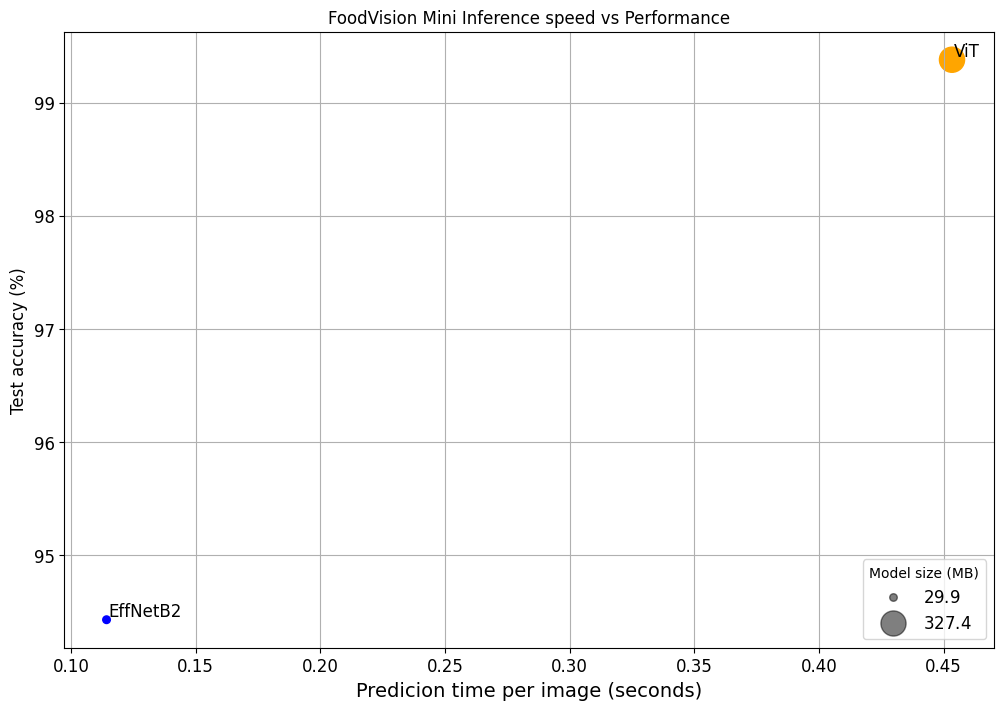

In [53]:
# 1. Create a plot from model comparison DataFrame
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(12,8))
scatter = ax.scatter(data=df,
                     x="time_per_pred_cpu",
                     y="test_acc",
                     c=["blue", "orange"],
                     s="model_size (MB)")

# 2. Add title and label to make our plot look good
ax.set_title("FoodVision Mini Inference speed vs Performance")
ax.set_xlabel("Predicion time per image (seconds)", fontsize=14)
ax.set_ylabel("Test accuracy (%)", fontsize=12)
ax.tick_params(axis="both", labelsize=12)
ax.grid(True)

# 3. Annote the sample on scatter plot
for index, row in df.iterrows():
  ax.annotate(text=row["model"],
              xy=(row["time_per_pred_cpu"] + 0.0006, row["test_acc"] + 0.03),
              size=12)

# 4. Create a legned based on the model size (model_size (MB))
handles, labels = scatter.legend_elements(prop="sizes", alpha=0.5)
model_size_legend = ax.legend(handles,
                               labels,
                               loc="lower right",
                               title="Model size (MB)",
                               fontsize=12)

# 5. Save the figure
plt.savefig("09-foodvision-mini-inference-speed-vs-performance.png")

## 7. Bringing FoodVision Mini to life by creating a Gradio Demo

What is Gradio ?
> Gradio is the fastest way to demo your machine learning model with a friendly web interface so that anyone can use it, anywhere! https://gradio.app/

In [54]:
# Import/install Gradio
try:
    import gradio as gr
except:
    !pip -q install gradio
    import gradio as gr

print(f"Gradio version: {gr.__version__}")

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.7/19.7 MB 62.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.0/57.0 kB 7.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 288.4/288.4 kB 33.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.4/75.4 kB 10.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 236.8/236.8 kB 30.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.5/50.5 kB 7.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 137.0/137.0 kB 17.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.7/45.7 kB 6.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 7.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.9/129.9 kB 17.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.4/50.4 kB 7.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.5/46.5 kB 6.0 MB/s eta 0

### 7.1 Gradio overview

### 7.2 Ceating a function to map our input and outputs

In [55]:
# Put our model on the CPU
effnetb2 = effnetb2.to("cpu")

# Check the device
next(iter(effnetb2.parameters())).device

device(type='cpu')

Let's create a funcion called `predict()` to go from:
```
image of food -> ML model (EffNetB2) -> outputs (food class label, prediction time)
```

In [56]:
from typing import Tuple, Dict

def predict(img) -> Tuple[Dict, float]:
  # Strat a timer
  start_time = time()

  # Transform the input image for use with EffnetB2
  img = effnetb2_transforms(img).unsqueeze(0) # Add batch dimension on 0th index


  # Put model into eval mode, make prediction
  effnetb2.eval()
  with torch.inference_mode():
    # Pass transformed image through the model and turn prediction logits into probabilities
    pred_probs = torch.softmax(effnetb2(img), dim=1)

  # Create a prediction label and prediction probability dictionary
  pred_labels_and_probs = {class_names[i]: float(pred_probs[0][i]) for i in range(len(class_names))}

  # Calculate pred time
  end_time = time()
  pred_time = round(end_time - start_time, 4)

  # Return pred dict and pred time
  return pred_labels_and_probs, pred_time

In [57]:
import random
from PIL import Image

# Get a list of all test image filepaths
test_data_paths = list(Path(test_dir).glob("*/*.jpg"))
test_data_paths[0]

# Radomly select a test image path
random_image_path = random.sample(test_data_paths, k=1)[0]
random_image_path

# Open the random image
image = Image.open(random_image_path)
print(f"[INFO] Predicting on image at path: {random_image_path}\n")

# Predict on the target imgage and print out the outputs
pred_dict, pred_time = predict(img=image)
print(pred_dict)
print(pred_time)

[INFO] Predicting on image at path: data/pizza_steak_sushi_20_percent/test/sushi/592799.jpg

{'pizza': 0.031161002814769745, 'steak': 0.06134151667356491, 'sushi': 0.9074974656105042}
0.1503


### 7.3 Creating a list of example images

In [58]:
example_list = [[str(filepath)] for filepath in random.sample(test_data_paths, k=3)]
example_list

[['data/pizza_steak_sushi_20_percent/test/pizza/419962.jpg'],
 ['data/pizza_steak_sushi_20_percent/test/steak/1523026.jpg'],
 ['data/pizza_steak_sushi_20_percent/test/pizza/1618659.jpg']]

### 7.4 Building a Gradio Interface

Let's use `gr.Interface()` to go form:

```Input: image -> transforms -> predict with EffNetB2 -> output: pred, prob porb, time ```

In [59]:
from sqlalchemy.sql.expression import desc
from tables import description
import gradio as gr

# Create title, description and article
title = "FoodVision Mini 🍕🥩🍣"
description = "An EfficientNetB2 feature extractor computer vision model to classify images of food as pizza, steak or sushi."
article = "Created at [09. PyTorch Model Deployment](https://www.learnpytorch.io/09_pytorch_model_deployment/)."

# Create the gradio Demo
demo = gr.Interface(fn=predict, # maps input to ouputs
                    inputs=gr.Image(type="pil"),
                    outputs = [gr.Label(num_top_classes=3, label="Predctions"),
                               gr.Number(label="Predction time (s)")],
                               examples=example_list,
                               title=title,
                               description=description,
                               artilcle=article)

# Launch the demo!
demo.launch(debug=False,  # print errors loacally ?
            share=True)  # generate a pubilically sharable URL

<ipython-input-59-1bfbb9706218>:11: UserWarning: You have unused kwarg parameters in Interface, please remove them: {'artilcle': 'Created at [09. PyTorch Model Deployment](https://www.learnpytorch.io/09_pytorch_model_deployment/).'}
  demo = gr.Interface(fn=predict, # maps input to ouputs


Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
Running on public URL: https://3928dfba94d5595e3e.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from Terminal to deploy to Spaces (https://huggingface.co/spaces)


## 8. Turing our FoodVision Mini Gradio Demo into a deployable app

```Colab -> Folder with all gradio files -> upload app files to Hugging Face Space -> deploy ```

File structure look likes this:
```
demos/
└── foodvision_mini/
    ├── 09_pretrained_effnetb2_feature_extractor_pizza_steak_sushi_20_percent.pth
    ├── app.py
    ├── examples/
    │   ├── example_1.jpg
    │   ├── example_2.jpg
    │   └── example_3.jpg
    ├── model.py
    └── requirements.txt
```

### 8.3 Creating a `demo` folder store our FoodVision app files

In [60]:
import shutil
from pathlib import Path

# Create FoodVision mini demo path
foodvision_mini_demo_path = Path("demo/foodvision_mini/")

# Remove files that might exits and create a new directory
if foodvision_mini_demo_path.exists():
  shutil.rmtree(foodvision_mini_demo_path)
  foodvision_mini_demo_path.mkdir(parents=True,
                                  exist_ok=True)
else:
  foodvision_mini_demo_path.mkdir(parents=True,
                                exist_ok=True)
!ls demo/foodvision_mini/

### 8.4 Creating a folder of example images to use with our FoodVision Mini demo

If we want to move images one file to another we can use `shutil`

In [61]:
import shutil
from pathlib import Path

# Create an examples directory
foodvision_mini_examples_path = foodvision_mini_demo_path / "example"
foodvision_mini_examples_path.mkdir(parents=True, exist_ok=True)

# Collect three random test dataset image paths
foodvision_mini_examples = [Path('data/pizza_steak_sushi_20_percent/test/sushi/592799.jpg'),
                            Path('data/pizza_steak_sushi_20_percent/test/steak/3622237.jpg'),
                            Path('data/pizza_steak_sushi_20_percent/test/pizza/2582289.jpg')]


# Copy the three images to the example directory
for example in foodvision_mini_examples:
  destination = foodvision_mini_examples_path / example.name
  print(f"[INFO] Copying {example} to {destination}")
  shutil.copy2(src=example,
               dst=destination)

[INFO] Copying data/pizza_steak_sushi_20_percent/test/sushi/592799.jpg to demo/foodvision_mini/example/592799.jpg
[INFO] Copying data/pizza_steak_sushi_20_percent/test/steak/3622237.jpg to demo/foodvision_mini/example/3622237.jpg
[INFO] Copying data/pizza_steak_sushi_20_percent/test/pizza/2582289.jpg to demo/foodvision_mini/example/2582289.jpg


`Gradio` Takes list of list

So that Let's now verifiry that we can get a list of lists from our `example`/ directory

In [62]:
import os

#  Get example filepath in a list of lists
example_list = [["example/" + example]  for example in os.listdir(foodvision_mini_examples_path)]
example_list

[['example/2582289.jpg'], ['example/592799.jpg'], ['example/3622237.jpg']]

### 8.5 Moving our trained EffnetB2 model to our FoodVision Mini demo direcrtory

In [63]:
import shutil

# Create a source path for our target model
effnetb2_foodvision_mini_model_path = "models/09_pretrained_effnetb2_feature_extractor_pizza_stack_sushi_20_percent.pth"

# Create a destination path for our target model
effnetb2_foodvision_mini_model_path_destination = foodvision_mini_demo_path / effnetb2_foodvision_mini_model_path.split("/")[1]

# Try to move the model file
try:
  print(f"[INFO] Attempting to move {effnetb2_foodvision_mini_model_path} to {effnetb2_foodvision_mini_model_path_destination}")

  # Move the model
  shutil.move(src=effnetb2_foodvision_mini_model_path,
              dst=effnetb2_foodvision_mini_model_path_destination)
except:
  print(f"[INFO] No model found at {effnetb2_foodvision_mini_model_path}, perhaps its already been moved?")
  print(f"[INFO] Model exists at {effnetb2_foodvision_mini_model_path_destination}: {effnetb2_foodvision_mini_model_path_destination.exists()}")

[INFO] Attempting to move models/09_pretrained_effnetb2_feature_extractor_pizza_stack_sushi_20_percent.pth to demo/foodvision_mini/09_pretrained_effnetb2_feature_extractor_pizza_stack_sushi_20_percent.pth


In [64]:
effnetb2_foodvision_mini_model_path

'models/09_pretrained_effnetb2_feature_extractor_pizza_stack_sushi_20_percent.pth'

In [65]:
effnetb2_foodvision_mini_model_path.split("/")[1]


'09_pretrained_effnetb2_feature_extractor_pizza_stack_sushi_20_percent.pth'

### 8.6 Turing off EffNetB2 model into a PyThon script (`model.py`)

In [66]:
%%writefile demo/foodvision_mini/model.py
import torch
import torchvision

from torch import nn


def create_effnetb2_model(num_classes:int=3,
                          seed:int=42):
    # reate EffNetB2 pretrained weights, transforms and model
    weights = torchvision.models.EfficientNet_B2_Weights.DEFAULT
    transforms = weights.transforms()
    model = torchvision.models.efficientnet_b2(weights=weights)

    # Freeze all layers in base model
    for param in model.parameters():
        param.requires_grad = False

    # Change classifier head with random seed for reproducibility
    torch.manual_seed(seed)
    model.classifier = nn.Sequential(
        nn.Dropout(p=0.3, inplace=True),
        nn.Linear(in_features=1408, out_features=num_classes),
    )

    return model, transforms

Writing demo/foodvision_mini/model.py


In [67]:
from demo.foodvision_mini import model

effnetb2_model, effnetb2_transforms_import = model.create_effnetb2_model()

### 8.7 Turning our FoodVision Mini Gradio app into a Python script(`app.py`)

1. Import and class names setup
2. Model and transforms prepration
3. Predict funtion(`predict()`)
4. Gradio.app - our Gradio interface + launch command

In [68]:
%%writefile demo/foodvision_mini/app.py
### 1. Imports and class names setup ###
import gradio as gr
import os
import torch

from model import create_effnetb2_model
from timeit import default_timer as time
from typing import Tuple, Dict

# Setup class names
class_names = ["pizza", "steak", "sushi"]

### 2. Model and transforms preparation ###

# Create EffNetB2 model
effnetb2, effnetb2_transforms = create_effnetb2_model(
    num_classes=3, # len(class_names) would also work
)

# Load saved weights
effnetb2.load_state_dict(
    torch.load(
        f="09_pretrained_effnetb2_feature_extractor_pizza_steak_sushi_20_percent.pth",
        map_location=torch.device("cpu"),  # load to CPU
    )
)

### 3. Predict function ###

# Create predict function
def predict(img) -> Tuple[Dict, float]:
    """Transforms and performs a prediction on img and returns prediction and time taken.
    """
    # Start the timer
    start_time = time()

    # Transform the target image and add a batch dimension
    img = effnetb2_transforms(img).unsqueeze(0)

    # Put model into evaluation mode and turn on inference mode
    effnetb2.eval()
    with torch.inference_mode():
        # Pass the transformed image through the model and turn the prediction logits into prediction probabilities
        pred_probs = torch.softmax(effnetb2(img), dim=1)

    # Create a prediction label and prediction probability dictionary for each prediction class (this is the required format for Gradio's output parameter)
    pred_labels_and_probs = {class_names[i]: float(pred_probs[0][i]) for i in range(len(class_names))}

    # Calculate the prediction time
    end_time = time()
    pred_time = round(end_time - start_time, 5)

    # Return the prediction dictionary and prediction time
    return pred_labels_and_probs, pred_time

### 4. Gradio app ###

# Create title, description and article strings
title = "FoodVision Mini 🍕🥩🍣"
description = "An EfficientNetB2 feature extractor computer vision model to classify images of food as pizza, steak or sushi."
article = "Created at [09. PyTorch Model Deployment](https://www.learnpytorch.io/09_pytorch_model_deployment/)."

# Create examples list from "examples/" directory
example_list = [["examples/" + example] for example in os.listdir("examples")]

# Create the Gradio demo
demo = gr.Interface(fn=predict, # mapping function from input to output
                    inputs=gr.Image(type="pil"), # what are the inputs?
                    outputs=[gr.Label(num_top_classes=3, label="Predictions"), # what are the outputs?
                             gr.Number(label="Prediction time (s)")], # our fn has two outputs, therefore we have two outputs
                    # Create examples list from "examples/" directory
                    examples=example_list,
                    title=title,
                    description=description,
                    article=article)

# Launch the demo!
demo.launch()

Writing demo/foodvision_mini/app.py


### 8.8 Creating `requirements.txt`

The requriement file will tell our Hugging face space what software dependencies our app requires.

The main ones are:
* `torch`
* `torchvision`
* `gradio`

In [69]:
%%writefile demo/foodvision_mini/requirements.txt

torch==1.12.0
torchvision==0.13.0
gradio==3.1.4

Writing demo/foodvision_mini/requirements.txt


## 9. Deploying our foodVision Mini app HuggingFace spaces

### 9.1 Downloading our foodvision Mini app files

We want to Download our `foodvision_mini` demo app so we can upload it to Hugging Face Spaces.

In [70]:
!ls demo/foodvision_mini/example

2582289.jpg  3622237.jpg  592799.jpg


In [71]:
# Change into foodvision_mini directory and then zip it form the inside
!cd demo/foodvision_mini && zip -r ../foodvision_mini.zip * -x "*.pyc" "*.ipynb" "*__pycache__*" "*ipynb_checkpoints*"

  adding: 09_pretrained_effnetb2_feature_extractor_pizza_stack_sushi_20_percent.pth (deflated 8%)
  adding: app.py (deflated 57%)
  adding: example/ (stored 0%)
  adding: example/2582289.jpg (deflated 17%)
  adding: example/592799.jpg (deflated 1%)
  adding: example/3622237.jpg (deflated 0%)
  adding: model.py (deflated 48%)
  adding: requirements.txt (deflated 6%)


### 9.3 Uploading our FoodVision Mini Gradio demo to Hugging Face Spaces

See here steps here: https://huggingface.co/spaces/Tushar-Thoriya/
foodvision_mini


In [72]:
# Ipython is a libaray to help make python iteractive
from IPython.display import IFrame

# Embed Foodvision Mini cradio demo
IFrame(src="https://hf.space/embed/Tushar-Thoriya/foodvision_mini/+", width=900, height=750)

## 10. Creating FoodVision Big!!!

### 10.1 Ceating a model for FoodVision Big + transforms

In [73]:
# Creating Food101 model and transforms
effnetb2_food101, effnetb2_transforms = create_effnetb2_model(num_classes=101)

In [74]:
from torchinfo import summary

summary(model=effnetb2_food101,
        input_size=(1, 3, 224, 224),
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [1, 3, 224, 224]     [1, 101]             --                   Partial
├─Sequential (features)                                      [1, 3, 224, 224]     [1, 1408, 7, 7]      --                   False
│    └─Conv2dNormActivation (0)                              [1, 3, 224, 224]     [1, 32, 112, 112]    --                   False
│    │    └─Conv2d (0)                                       [1, 3, 224, 224]     [1, 32, 112, 112]    (864)                False
│    │    └─BatchNorm2d (1)                                  [1, 32, 112, 112]    [1, 32, 112, 112]    (64)                 False
│    │    └─SiLU (2)                                         [1, 32, 112, 112]    [1, 32, 112, 112]    --                   --
│    └─Sequential (1)                                        [1, 32, 112, 112]    [1, 1

In [75]:
# Create traing data transforms
food101_train_transforms = torchvision.transforms.Compose([torchvision.transforms.TrivialAugmentWide(),
                                                      effnetb2_transforms])

In [76]:
food101_train_transforms

Compose(
    TrivialAugmentWide(num_magnitude_bins=31, interpolation=InterpolationMode.NEAREST, fill=None)
    ImageClassification(
    crop_size=[288]
    resize_size=[288]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BICUBIC
)
)

### 10.2 Getting data for FoodVision Big

In [77]:
from torchvision import datasets

# Setup data directory
from pathlib import Path
data_dir = Path("data")

# Get the training data (`750 x 100 classes)
import torchvision
from torchvision import datasets

# Get training data (~750 x 101 classes)
train_data = datasets.Food101(root=data_dir,
                              split="train",
                              transform=food101_train_transforms,    # apply data augmentation to train data
                              download=True)

test_data = datasets.Food101(root=data_dir,
                             split="test",
                             transform=effnetb2_transforms,       # don't perform data augmentation on the test data
                             download=True)

100%|██████████| 4996278331/4996278331 [05:44<00:00, 14510090.92it/s]


Extracting data/food-101.tar.gz to data


In [78]:
# Get Food101 class names
food101_class_names = train_data.classes

food101_class_names[:10]

['apple_pie',
 'baby_back_ribs',
 'baklava',
 'beef_carpaccio',
 'beef_tartare',
 'beet_salad',
 'beignets',
 'bibimbap',
 'bread_pudding',
 'breakfast_burrito']

In [79]:
import os
import torch

NUM_WORKERS = 2
BATCH_SIZE = 32

# Create Food101 training DataLoaders
train_food101_dataloaders = torch.utils.data.DataLoader(dataset=train_data,
                                                                   batch_size=BATCH_SIZE,
                                                                   shuffle=True,
                                                                   num_workers=NUM_WORKERS)

# Create Food101 testing DataLoader
test_food101_dataloaders = torch.utils.data.DataLoader(dataset=test_data,
                                                             batch_size=BATCH_SIZE,
                                                             shuffle=False,
                                                             num_workers=NUM_WORKERS)

### 10.3 Creating a subset of the food101 dataset for faster experimenting

In [80]:
from torch.utils.data import random_split

def split_dataset(dataset:torchvision.datasets,
                  split_size:float=0.2,
                  seed:int=42):
  # Create split length on original length
  length_1 = int(len(dataset) * split_size)
  length_2 = len(dataset) - length_1

  # Print out info
  print(f"[INFO] Spliting dataset of length {len(dataset)} into split of size : {length_1} and {length_2}")

  # Creating splits with random seed
  random_split_1, random_split_2 = torch.utils.data.random_split(dataset,
                                                            lengths=[length_1, length_2],
                                                            generator=torch.manual_seed(seed))
  return random_split_1, random_split_2

In [81]:
# Create training 20% split Food101
train_data_food101_20_percent, _ = split_dataset(dataset=train_data,
                                                split_size=0.2)

test_data_food101_20_percent, _ = split_dataset(dataset=test_data,
                                                split_size=0.2)

[INFO] Spliting dataset of length 75750 into split of size : 15150 and 60600
[INFO] Spliting dataset of length 25250 into split of size : 5050 and 20200


In [82]:
len(train_data_food101_20_percent), len(test_data_food101_20_percent)

(15150, 5050)

### 10.4 Turning our Food101 datasets into `DataLoaders`

In [83]:
import os
import torch

NUM_WORKERS = 2
BATCH_SIZE = 32

# Create Food101 20% training DataLoaders
train_dataloaders_food101_20_percent = torch.utils.data.DataLoader(dataset=train_data_food101_20_percent,
                                                                   batch_size=BATCH_SIZE,
                                                                   shuffle=True,
                                                                   num_workers=NUM_WORKERS)

# Create Food101 20% testing DataLoader
test_dataloaders_food101_20_percent = torch.utils.data.DataLoader(dataset=test_data_food101_20_percent,
                                                             batch_size=BATCH_SIZE,
                                                             shuffle=False,
                                                             num_workers=NUM_WORKERS)

In [84]:
len(train_dataloaders_food101_20_percent), len(test_dataloaders_food101_20_percent)

(474, 158)

### 10.5 Training FoodVision Big!!!

Things for Training:
* 5 epoch
* Optimizer: `torch.optim.Adam(lr=1e-1)`
* Loss function: `torch.nn.CrossEntroPyLoss(label_smoothing=0.1)`

Why use label smooting ?

Label smooting helps to prevent ovetfitting (It's regularization technique)

Without label smooting and 5 classes:
```[0.00, 0.00, 0.99, 0.01, 0.00]```

With label smooting and 5 classes:
```[0.01, 0.01, 0.96, 0.01, 0.01]```

In [ ]:
from going_modular.going_modular import engine

# Setup optimizer
optimizer = torch.optim.Adam(params=effnetb2_food101.parameters(),
                             lr=1e-3)

# Setup loss
loss_fn = torch.nn.CrossEntropyLoss(label_smoothing=0.1)

# Want to beat the original food101 paper's result of 56.4% accuracy on test dataset with 20% of the data
set_seeds()
effnetb2_food101_results = engine.train(model=effnetb2_food101,
                                        # train_dataloader=train_dataloaders_food101_20_percent,
                                        train_dataloader=train_food101_dataloaders,
                                        # test_dataloader=test_dataloaders_food101_20_percent,
                                        test_dataloader=test_food101_dataloaders,
                                        optimizer=optimizer,
                                        loss_fn = loss_fn,
                                        epochs=20,
                                        device=device)

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 2.9770 | train_acc: 0.4090 | test_loss: 2.1895 | test_acc: 0.6062
Epoch: 2 | train_loss: 2.6479 | train_acc: 0.4821 | test_loss: 2.1095 | test_acc: 0.6269
Epoch: 3 | train_loss: 2.6149 | train_acc: 0.4908 | test_loss: 2.0682 | test_acc: 0.6400
Epoch: 4 | train_loss: 2.5939 | train_acc: 0.4970 | test_loss: 2.0573 | test_acc: 0.6413
Epoch: 5 | train_loss: 2.5934 | train_acc: 0.4974 | test_loss: 2.0499 | test_acc: 0.6450
Epoch: 6 | train_loss: 2.5847 | train_acc: 0.4991 | test_loss: 2.0310 | test_acc: 0.6537
Epoch: 7 | train_loss: 2.5928 | train_acc: 0.4978 | test_loss: 2.0392 | test_acc: 0.6478
Epoch: 8 | train_loss: 2.5902 | train_acc: 0.5011 | test_loss: 2.0637 | test_acc: 0.6405
Epoch: 9 | train_loss: 2.5938 | train_acc: 0.4975 | test_loss: 2.0541 | test_acc: 0.6453
Epoch: 10 | train_loss: 2.5861 | train_acc: 0.5036 | test_loss: 2.0226 | test_acc: 0.6556
Epoch: 11 | train_loss: 2.5889 | train_acc: 0.5020 | test_loss: 2.0276 | test_acc: 0.6495
Epoch: 12 | train_l

### 10.6 Inspecting loss curves of Foodvision Big model

In [ ]:
from helper_functions import plot_loss_curves

plot_loss_curves(effnetb2_food101_results)

### 10.7 Save and load FoodVision Big Model

In [ ]:
from going_modular.going_modular import utils

# Creating a model path
effnetb2_food101_model_path =  "09_pretrained_effnetb2_feature_extractor_food101_20_percent.pth"

# Save FoodVision Big Model
utils.save_model(model=effnetb2_food101,
                 target_dir='models/',
                 model_name=effnetb2_food101_model_path)

In [ ]:
# Create Food101 compatible EffnetB2 instance
loaded_effnetb2_food101, effnetb2_transforms = create_effnetb2_model(num_classes=101)

# Load the saved model's state_dict()
loaded_effnetb2_food101.load_state_dict(torch.load("models/09_pretrained_effnetb2_feature_extractor_food101_20_percent.pth"))

### 10.8 Checking FoodVision Big Model size

In [ ]:
from pathlib import Path

# Get the model size in bytes then convert to megabyte
pretrained_effnetb2_model_size = Path("model", effnetb2_food101_model_path).stat().st_size // (1024*1024)
print(f"Pretrained EffnetB2 feature extractor Food101 model size: {pretrained_effnetb2_model_size}")

## 11. Turning our Foodvision Big model into a deployeble app
```
demos/
  foodvision_big/
    09_pretrained_effnetb2_feature_extractor_food101_20_percent.pth
    app.py
    class_names.txt
    examples/
      example_1.jpg
    model.py
    requirements.txt
```

In [ ]:
from pathlib import Path

# Create FoodVision Big demo Path
foodvision_big_demo_path = Path("demo/foodvision_big/")

# Make Foodvision Big demo directory
foodvision_big_demo_path.mkdir(parents=True,
                               exist_ok=True)

# Make Foodvision Big demo examples directory
(foodvision_big_demo_path/"examples").mkdir(parents=True,
                                            exist_ok=True)

### 11.1 Downloading an example image and moving it to the `example` directory

In [ ]:
# Download nad move exmaple image
!wget https://github.com/mrdbourke/pytorch-deep-learning/blob/58d70f5f9ea0ef3265478209b3223c1f1cae5363/images/04-pizza-dad.jpeg
!mv 04-pizza-dad.jpeg demo/foodvision_big/examples/04-pizza-dad.jpeg

In [ ]:
!mv models/09_pretrained_effnetb2_feature_extractor_food101_20_percent.pth demo/foodvision_big

### 11.2 Saving Food101 class names to file (`class_names.txt`)

In [ ]:
# Check out the 10 Food101 class names
food101_class_names[:10]

In [ ]:
foodvision_big_class_names_path = foodvision_big_demo_path/"class_names.txt"
foodvision_big_class_names_path

In [ ]:
# write Food101 class names to text file
with open(foodvision_big_class_names_path, "w") as f:
  print(f"[INFO] Saving food101 class names.......")
  f.write("\n".join(food101_class_names))

In [ ]:
# Open Food101 class names file read each line into a list
with open(foodvision_big_class_names_path, "r") as f:
  food101_class_names_loaded = [food.strip() for food in f.readlines()]

food101_class_names_loaded[:10]

### 11.3 Turining our Foodvision Big Modle into a Python script(`model.py`)

In [ ]:
%%writefile demo/foodvision_big/model.py
import torch
import torchvision

from torch import nn


def create_effnetb2_model(num_classes:int=3,
                          seed:int=42):
    # reate EffNetB2 pretrained weights, transforms and model
    weights = torchvision.models.EfficientNet_B2_Weights.DEFAULT
    transforms = weights.transforms()
    model = torchvision.models.efficientnet_b2(weights=weights)

    # Freeze all layers in base model
    for param in model.parameters():
        param.requires_grad = False

    # Change classifier head with random seed for reproducibility
    torch.manual_seed(seed)
    model.classifier = nn.Sequential(
        nn.Dropout(p=0.3, inplace=True),
        nn.Linear(in_features=1408, out_features=num_classes),
    )

    return model, transforms

### 11.4 Turning our foodvision Big Cradio app into a Python script (`app.py`)

1. Import and class names setup - for class name import from `class_names.txt`
2. Model and transforms preparation
3. Predict funtion(`predict()`)
4. Gradio.app - our Gradio interface + launch command

In [ ]:
%%writefile demo/foodvision_big/app.py
### 1. Import and class names setup ###
import gradio as gr
import os
import torch

from model import create_effnetb2_model
from timeit import default_timer as time
from typing import Tuple, Dict

# Setup class name
with open("class_names.txt", "r") as f:
  class_names = [food_name.strip() for food_name in f.readlines()]

### 2. Model and transforms preparation ###
# Create model and transforms
effnetb2, effnetb2_transforms = create_effnetb2_model(num_classes=101)

# Load save weights
effnetb2.load_state_dict(
    torch.load(f="09_pretrained_effnetb2_feature_extractor_food101_20_percent.pth",
               map_location=torch.device("cpu")) # Load on CPU
)

### 3. Predict function ###
def predict(img) -> Tuple[Dict, float]:
    # Start the timer
    start_time = time()

    # Transform the target image and add a batch dimension
    img = effnetb2_transforms(img).unsqueeze(0)

    # Put model into evaluation mode and turn on inference mode
    effnetb2.eval()
    with torch.inference_mode():
        # Pass the transformed image through the model and turn the prediction logits into prediction probabilities
        pred_probs = torch.softmax(effnetb2(img), dim=1)

    # Create a prediction label and prediction probability dictionary for each prediction class (this is the required format for Gradio's output parameter)
    pred_labels_and_probs = {class_names[i]: float(pred_probs[0][i]) for i in range(len(class_names))}

    # Calculate the prediction time
    end_time = time()
    pred_time = round(end_time - start_time, 5)

    # Return the prediction dictionary and prediction time
    return pred_labels_and_probs, pred_time

### 4. Gradio app ###
# Create title, description and article strings
title = "FoodVision BIG 🍔👁"
description = "An EfficientNetB2 feature extractor computer vision model to classify images 101 classes of food from the Food101 dataset."
article = "Created at [09. PyTorch Model Deployment](https://www.learnpytorch.io/09_pytorch_model_deployment/#11-turning-our-foodvision-big-model-into-a-deployable-app)."

# Create examples list from "examples/" directory
example_list = [["examples/" + example] for example in os.listdir("examples")]

# Create the Gradio demo
demo = gr.Interface(fn=predict, # mapping function from input to output
                    inputs=gr.Image(type="pil"), # what are the inputs?
                    outputs=[gr.Label(num_top_classes=5, label="Predictions"), # what are the outputs?
                             gr.Number(label="Prediction time (s)")], # our fn has two outputs, therefore we have two outputs
                    # Create examples list from "examples/" directory
                    examples=example_list,
                    title=title,
                    description=description,
                    article=article)

# Launch the demo!
demo.launch()


### 11.5 Creating a requirements file for FoodVision Big (`requrements.txt`)

In [ ]:
%%writefile demo/foodvision_big/requirements.txt
torch==1.12.0
torchvision==0.13.0
gradio==3.1.4

### 11.6 Downloading our FoodVision Big app files


In [ ]:
# Change into foodvision_big directory and then zip it form the inside
!cd demo/foodvision_big && zip -r ../foodvision_big.zip * -x "*.pyc" "*.ipynb" "*__pycache__*" "*ipynb_checkpoints*"

### 11.7 Deploying our Foodvision Big model app to Hugging Fases Spaces


In [ ]:
# IPython is a library to help work with Python iteractively
# from IPython.display import IFrame

# # Embed FoodVision Big Gradio demo as an iFrame
# IFrame(src="https://hf.space/embed/Tushar-Thoriya/foodvision_big/+", width=900, height=750)